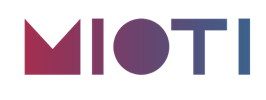
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Computer Vision</center>
<center style="color:#aaa; margin-top:10px;">Prof. Diego García Morate<br>diegogm@faculty.mioti.es</center>


# Challenge S3: Contador de coches

## Objetivos

El objetivo de este challenge es que hagamos un algoritmo capaz de contar cuantos coches circulan en una carretera a partir de una secuencia de vídeo de entrada.

Por facilitar la consecución del challenge, en esta versión del challenge trabajaremos con unos pocos frames.

## Configuración del entorno

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data, io, filters
from skimage.color import rgb2gray
from skimage.feature import blob_doh
from skimage.filters import threshold_otsu
from skimage.morphology import opening, closing, erosion, dilation, disk

In [2]:
def mostrar_frames(video):
    """Muestra una secuencia de frames almacenada en una lista"""
    for frame in video:
        io.imshow(frame)
        io.show()

In [3]:
def mostrar_blobs(img, blobs):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    for blob in blobs:    
        y, x, r = blob
        c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
        ax.add_artist(c)

## Carga de imágenes

En este caso vamos a trabajar en vez de una única imagen con una secuencia de imágenes. Para tratar con estos datos `skimage` nos proporciona algunas funciones que nos ahorran el trabajo como `ImageCollection`.

Podemos cargar una secuencia de imágenes de la siguiente manera:

In [4]:
video_rgb = io.ImageCollection('highway/*.png')
print(len(video_rgb))

10


Podemos acceder a la primera imagen accediendo directamente a la primera posición del array.

In [5]:
print(video_rgb[0].shape)

(354, 630, 3)


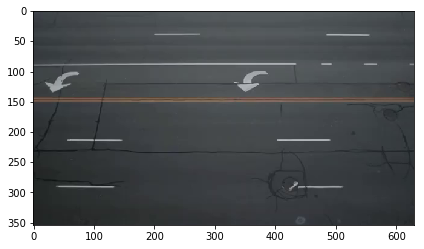

In [6]:
io.imshow(video_rgb[0])
io.show()

## Conversión a grises

El primer paso que vamos a dar es convertir a escala de grises cada uno de los frames de la secuencia a procesar:

In [7]:
def convierte_a_gris(video):
    ''' 
    Convierte la secuencia de entrada en RGB a una secuencia en escala de grises
    Recibe una lista de frames (vide) y devuelve una secuencia de frames de salida
    '''
    out = []
    for data in video:
        try:
            img_gray = rgb2gray(data)
            #img_mono = umbral_fijo(img_gray, 0.5)
            out.append(img_gray)
        except:
            pass
        
    #img_mono = umbral_fijo(img_gray, 0.5)
    
    # ESCRIBE AQUÍ TU CÓDIGO: 
    # Tip: Tendrás que recorrer cada frame, convertirlo a grises y devolverlo en una lista

    return out

def umbral_fijo(img, umbral):
    """Binariza una imagen en escala de grises a partir de un umbral"""
    return img > umbral

In [8]:
video_gris = convierte_a_gris(video_rgb)

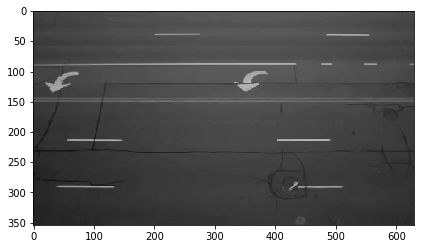

In [9]:
io.imshow(video_gris[0])
io.show()

## Análisis de diferencias

El siguiente paso que vamos a dar es realizar un análisis de diferencias que consiste en restar dos imágenes píxel a píxel para resaltar las diferencias entre ellas.

$$IMG_{dif} = Abs(IMG_{n} - IMG_{n-1})$$

En este caso el análisis de diferencias nos va a permitir identificar los píxels que han cambiado entre dos frames consecutivos (movimiento).

In [10]:
def calcula_diferencias(video):
    ''' 
    Realiza el análisis de diferencias entre frames consecutivos para el video de entrada
    Devuelve una secuencia de frames de salida
    '''
    out = []
    i=1
    while i < len(video):
        diff = abs(video[i] - video[i - 1])
        out.append(diff)
        i += 1
    
    return out

In [11]:
video_dif = calcula_diferencias(video_gris)

/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


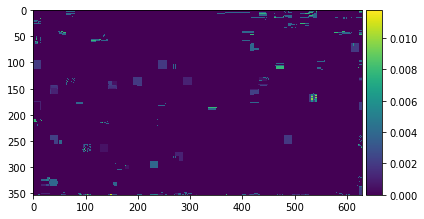

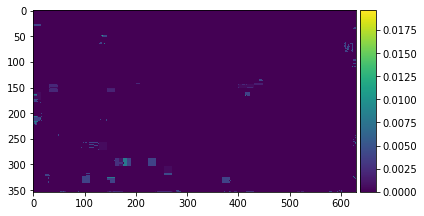

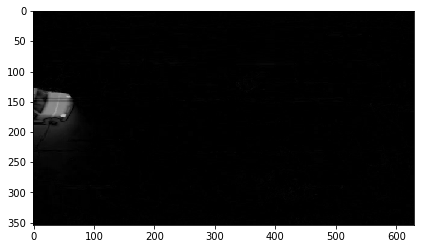

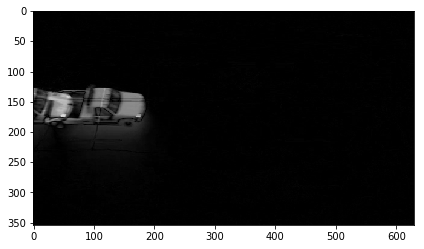

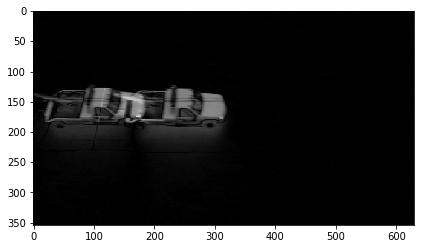

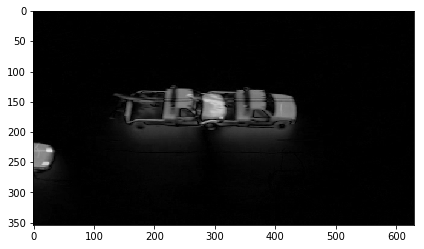

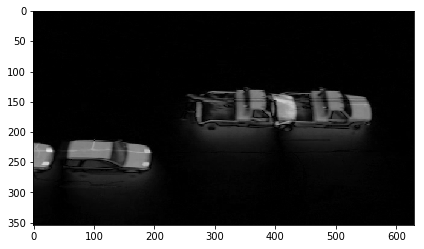

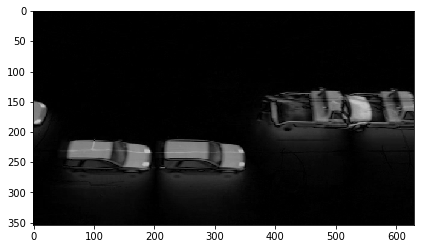

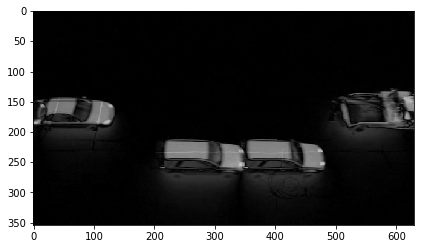

In [12]:
mostrar_frames(video_dif)

Viendo el resultado, ¿Cuáles es el principal problema que observas? ¿se te ocurre alguna manera de mejorarlo?

* Al restar dos frames consecutivos aparece información de ambos frames, cuando sería más deseable que apareciera información únicamente del movimiento del frame actual.
* Podemos mejorarlo si en vez de restar un frame del siguiente lo restarámos de un "fondo", entendiendo fondo como aquello que aparece si no hay nada de movimiento.

## Extración de fondo

El siguiente paso que te propongo es que pienses que frame, o combinación de frames, puede ser un buen candidato de "fondo" y que implementes la siguiente función:

*Tip: A lo mejor algún estadístico aplicado sobre todos los frames o algún frame en concreto pueden ser buenos candidatos... Si lo piensas el fondo es todo aquello que es regular a lo largo del tiempo.*

In [13]:
def extrae_fondo(video):
    '''Determina el fondo a partir de los frames de entrada y devuelve un frame de salida'''

    # ESCRIBE AQUÍ TU CÓDIGO
    fondo = sum(video)/len(video)
    
    return fondo

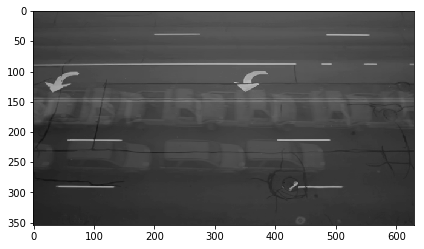

In [14]:
fondo = extrae_fondo(video_gris)
io.imshow(fondo)
io.show()

## Análisis de diferencias con el fondo

Una vez obtenido el fondo deseado repetimos el análisis de diferencias, en vez de hacerlo con frames consecutimos del frame actual vs el fondo que hemos calculado en el paso anterior.

$$IMG_{dif} = Abs(IMG_{n} - IMG_{fondo})$$

In [15]:
def calcula_diferencias_fondo(video, fondo):
    ''' 
    Realiza el análisis de diferencias con el fondo
    Devuelve una secuencia de frames de salida
    '''
    out = []
    i=0
    while i < len(video):
        diff = abs(video[i] - fondo)
        out.append(diff)
        i += 1
    
    return out

In [16]:
fondo = video_gris[0]

In [17]:
video_dif_fondo = calcula_diferencias_fondo(video_gris, fondo)

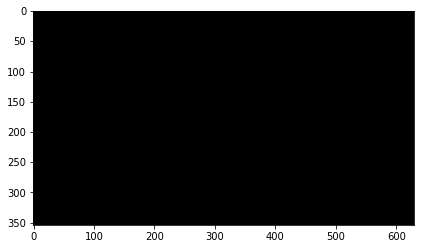

/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


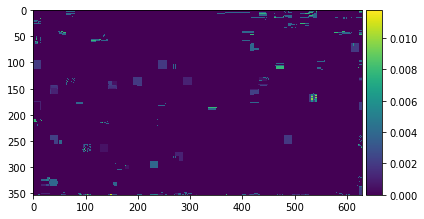

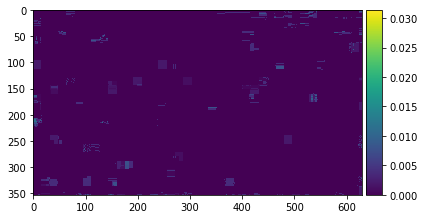

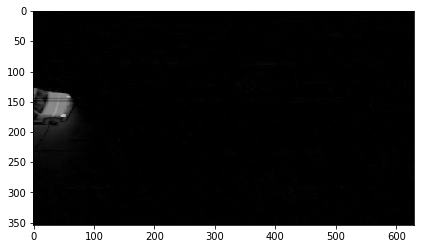

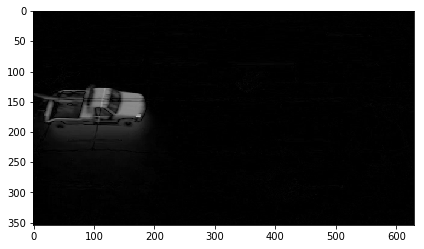

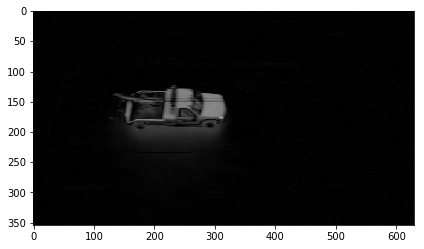

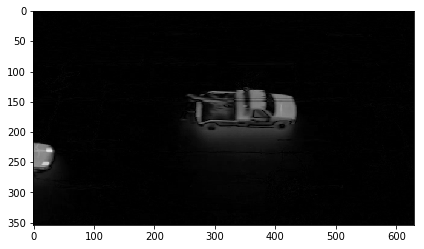

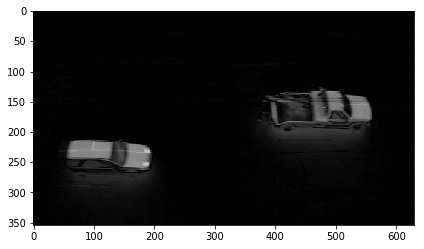

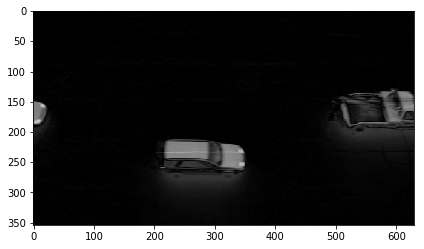

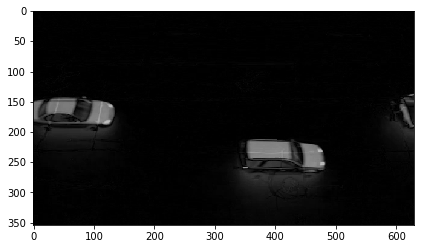

In [18]:
mostrar_frames(video_dif_fondo)

## Binarización
El siguiente paso que os propongo es binarizar la imagen de diferencias con el objetivo de enmascar los resultados en la etapa siguiente. 

In [19]:
def binariza_video(video):
    out = []
    
    # ESCRIBE AQUÍ TU CÓDIGO
    for frame in video:
        try:
            otsu = threshold_otsu(frame)
            img_mono = umbral_fijo(frame, otsu)
            out.append(img_mono)
        except:
            img_mono = umbral_fijo(frame, 0.5)
            out.append(img_mono)
    
#     io.imshow(img_mono)
#     io.show()
    
    return out

def umbral_fijo(img, umbral):
    """Binariza una imagen en escala de grises a partir de un umbral"""
    return img > umbral

In [20]:
video_dif_fondo_umbralizada = binariza_video(video_dif_fondo)

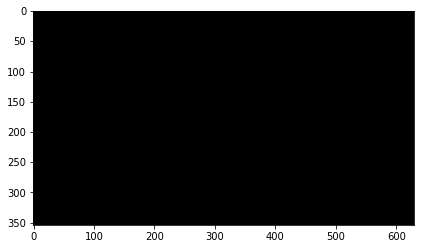

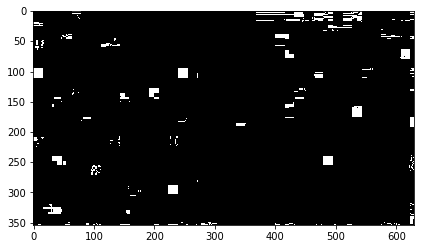

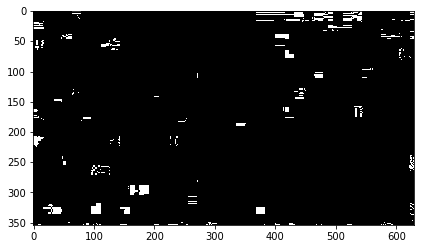

/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


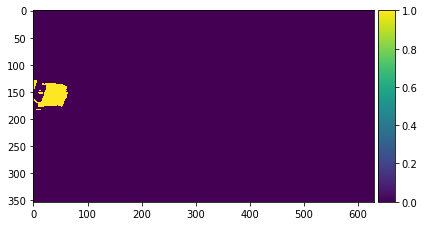

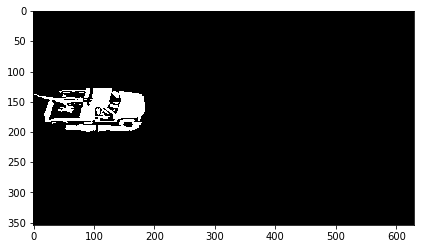

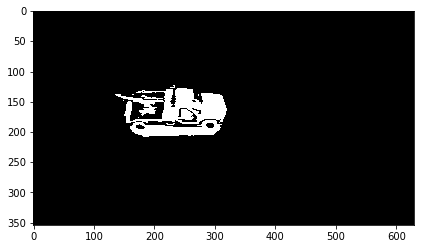

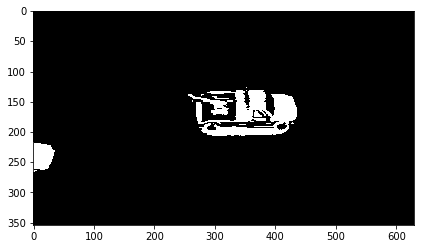

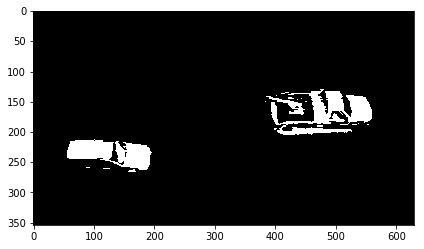

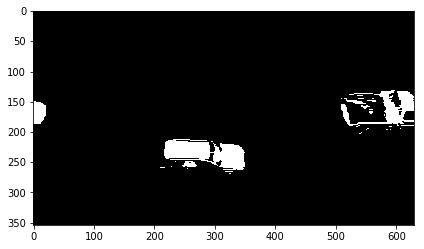

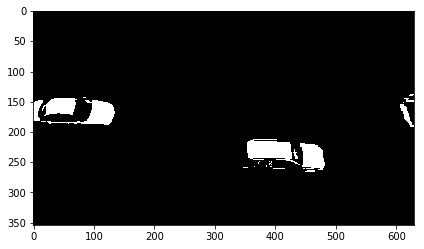

In [21]:
mostrar_frames(video_dif_fondo_umbralizada)

## Análisis de blobs
Una vez obtenida la máscara binarizada te propongo que extraígamos los blobs de la imagen:

In [22]:
def extraer_blobs(video):
    '''
    Obtiene los blobs de cada frame de video.
    Devuelve una lista de blobs por cada frame del video.
    '''
    all_blobs = []
    for frame in video:
        all_blobs.append(blob_doh(frame, max_sigma=125, threshold=0.025))
    # ESCRIBE AQUÍ TU CÓDIGO
    # Por cada frame deberás extraer los blobs y almacenarlos en una lista.
    
    return all_blobs

In [23]:
all_blobs = extraer_blobs(video_dif_fondo_umbralizada)

Mostramos los resultados:

[0] Blobs: 0
[1] Blobs: 81
[2] Blobs: 79
[3] Blobs: 1
[4] Blobs: 4
[5] Blobs: 2
[6] Blobs: 5
[7] Blobs: 3
[8] Blobs: 4
[9] Blobs: 5


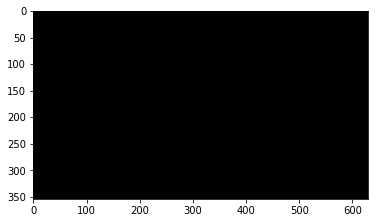

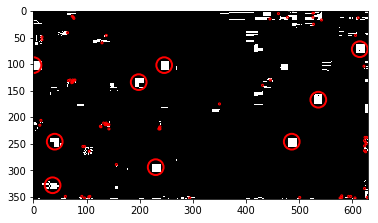

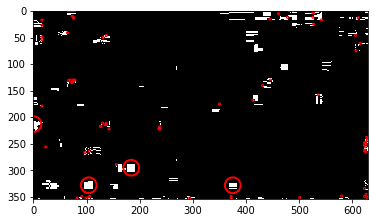

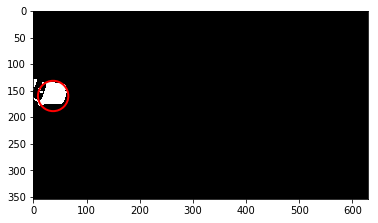

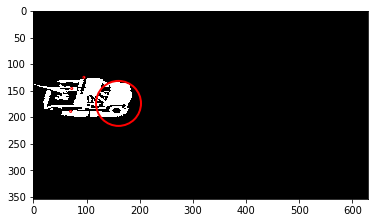

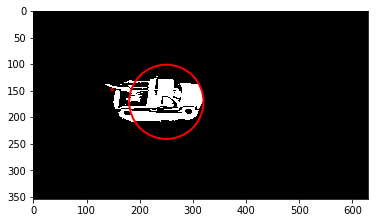

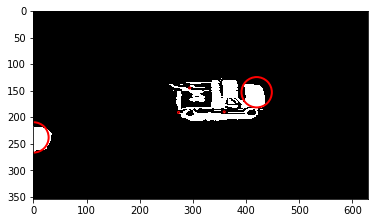

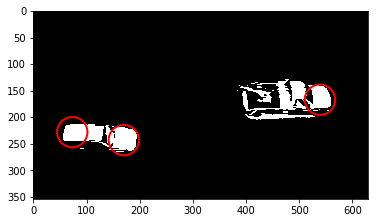

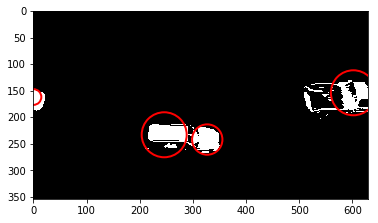

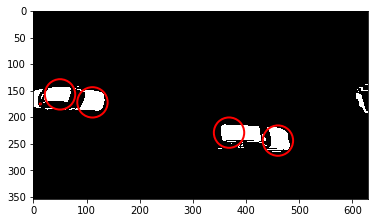

In [24]:
for i in range(len(video_dif_fondo_umbralizada)):
    img = video_dif_fondo_umbralizada[i]
    blobs = all_blobs[i]
    
    mostrar_blobs(img, blobs)
    print("[{}] Blobs: {}".format(i, len(blobs)))

## Preguntas finales

* ¿Cuantos coches aparecen en cada frame?
* ¿Qué ventajas e inconvenientes le ves a este pipeline de análisis?

En cada frame se puede observar entre 1 y 2 coches, coincidiendo la detección de blobs con la agregacion de puntos blancos. 

Este pipeline es beneficioso para detección rápida de eventos o cosas desentonantes en la imagen, con un procesamiento bastante rápido,  como la aplicación de contar el tráfico mediante esta técnica. Por otro lado, si el objetivo es encontrar detalles como por ejemplo leer caracteres, puede convertirse en una tarea más complicada.


## (extra) Filtrado de blobs

¿Se te ocurre alguna manera de mejorar los blobs que hemos obtenido en la etapa anterior?. ¿Podríamos filtrar blobs que a priori sepamos que están mal?

In [25]:
def es_blob_valido(blob):
    posicion_y, posicion_x, radio = blob
    
    # ESCRIBE AQUÍ TU CÓDIGO
    
    # Devuelve True si el blob es bueno, False en caso contrario
    return True

Ahora aplicamos el filtro que hemos implementado:

In [26]:
def filtrar_blobs(all_blobs):
    """Recorre todos los blobs de cada frame y almacena sólo los blobs que satisfacen es_blob_valido"""
    all_blobs_filtered = []

    for blobs in all_blobs:
        blobs_filtered = []

        for blob in blobs:
            if es_blob_valido(blob):
                blobs_filtered.append(blob)

        all_blobs_filtered.append(blobs_filtered)
        
    return all_blobs_filtered

In [27]:
all_blobs_filtered = filtrar_blobs(all_blobs)

Coches: 0
Coches: 81
Coches: 79
Coches: 1
Coches: 4
Coches: 2
Coches: 5
Coches: 3
Coches: 4
Coches: 5


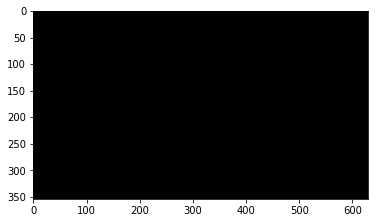

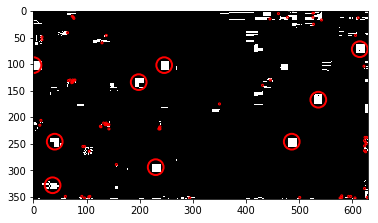

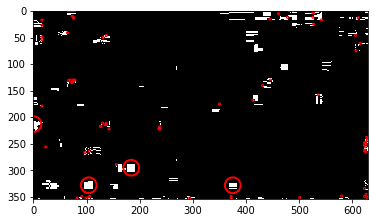

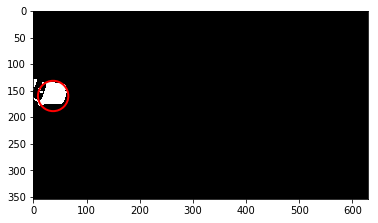

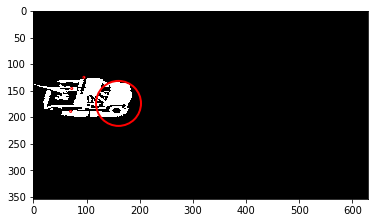

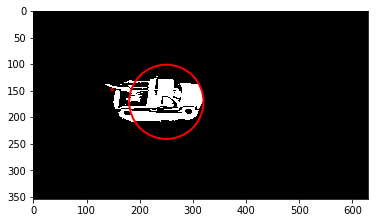

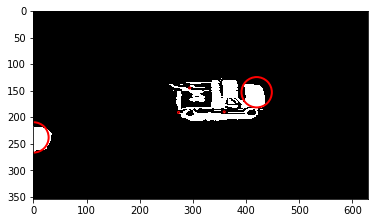

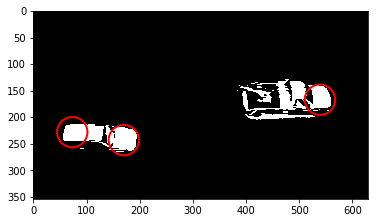

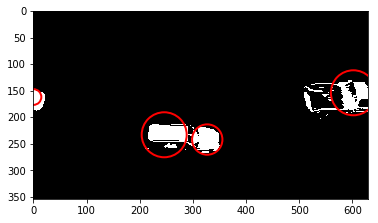

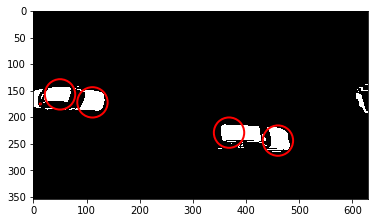

In [28]:
for i in range(len(video_dif_fondo_umbralizada)):
    mostrar_blobs(video_dif_fondo_umbralizada[i], all_blobs_filtered[i])
    print("Coches: " + str(len(all_blobs_filtered[i])))